In [134]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 路径声明

In [135]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 设定分类数

In [136]:
NUM_CLASSES = 8

# 读取学习数据

In [137]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [138]:
# 读入从1到21*2的数据（表的每行共有21个数据（对应21个特征点） 每个数据有两个值（xy坐标轴值））作为x

In [139]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [140]:
# 第0列的值代表属于哪种手势

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 模型构建

In [142]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [143]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_12 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 88        
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [144]:
# 模型检查点回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 用于提前结束的回调
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [145]:
# 模型编译
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 模型训练

In [146]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

fier.hdf5
Epoch 37/1000
51/51 [==============================] - 0s 5ms/step - loss: 1.1196 - accuracy: 0.5627 - val_loss: 0.8093 - val_accuracy: 0.8033

Epoch 00037: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 38/1000
51/51 [==============================] - 0s 6ms/step - loss: 1.1208 - accuracy: 0.5574 - val_loss: 0.7953 - val_accuracy: 0.7863

Epoch 00038: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 39/1000
51/51 [==============================] - 0s 5ms/step - loss: 1.1034 - accuracy: 0.5722 - val_loss: 0.8044 - val_accuracy: 0.7877

Epoch 00039: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 40/1000
51/51 [==============================] - 0s 5ms/step - loss: 1.1011 - accuracy: 0.5728 - val_loss: 0.8010 - val_accuracy: 0.7560

Epoch 00040: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 41/1000
51/51 [==============================] - 0s 5ms/step - loss: 1.0797 - accuracy: 

In [147]:
# 模型评估
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

17/17 [==============================] - 0s 2ms/step - loss: 0.7099 - accuracy: 0.8300


In [148]:
# 加载保存的模型
model = tf.keras.models.load_model(model_save_path)

In [149]:
# 推理测试
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[4.4066653e-01 1.4638079e-03 2.0099564e-01 2.9034895e-01 2.5418992e-04
 1.1503961e-03 3.0634562e-02 3.4485985e-02]
0


# 混淆矩阵

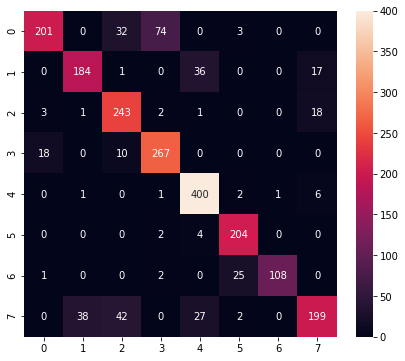

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.65      0.75       310
           1       0.82      0.77      0.80       238
           2       0.74      0.91      0.82       268
           3       0.77      0.91      0.83       295
           4       0.85      0.97      0.91       411
           5       0.86      0.97      0.91       210
           6       0.99      0.79      0.88       136
           7       0.83      0.65      0.73       308

    accuracy                           0.83      2176
   macro avg       0.85      0.83      0.83      2176
weighted avg       0.84      0.83      0.83      2176



In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# 转化为Tensorflow-Lite用模型

In [151]:
# 保存为仅供推理的模型
model.save(model_save_path, include_optimizer=False)

In [152]:
# 转换模型（量化）
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Van5SE\AppData\Local\Temp\tmpc1b6wv8w\assets
INFO:tensorflow:Assets written to: C:\Users\Van5SE\AppData\Local\Temp\tmpc1b6wv8w\assets


6592

# 推理测试

In [153]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [154]:
# 获取 I/O 张量
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [155]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [156]:
%%time
# 推理实施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [157]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.4066653e-01 1.4638072e-03 2.0099568e-01 2.9034889e-01 2.5419015e-04
 1.1503961e-03 3.0634575e-02 3.4485985e-02]
0
